This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# 4. Getting started with neural networks: Classification and regression
1. [Binary Classification: IMDB Reviews](#binclas)
1. [Multiclass Classification: Newswires](#multiclass)

<a name='binclas'></a>
## 4.1 Classifying movie reviews: A binary classification example

<a name="data"></a>
### The IMDB dataset

**Loading the IMDB dataset**

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

The variables `train_data` and `test_data` are __lists of reviews__; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where `0` stands for __negative__ and `1` stands for __positive__.

In [8]:
print(train_data[0], "\n")
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 

1


**Decoding reviews back to text**

In [9]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review[:100]

"? this film was just brilliant casting location scenery story direction everyone's really suited the"

<a name="preparing"></a>
### Preparing the data

You can’t directly feed lists of integers into a NN. They all have different lengths, but __a NN expects to process contiguous batches of data__. You have to __turn your lists into tensors__. There are 2 ways to do that:

1. __Pad your lists__ so that they all have the same length, turn them into an integer tensor of shape `(samples, max_length)`, and start your model with a layer capable of handling such integer tensors.

2. __Multi-hot encode your lists__ to turn them into vectors of 0s and 1s. Then you could use a `Dense` layer, capable of handling floating-point vector data, as the first layer in your model.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.

**Encoding the integer sequences via multi-hot encoding**

In [10]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [12]:
# vectorize labels
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

<a name="building"></a>
### Building your model

The __input data is vectors__, and the __labels are scalars__ (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a __plain stack of `Dense` layers with `relu` activations__.

There are two __key architecture decisions__ to be made about such a stack of Dense layers:

1. How many layers to use
2. How many units to choose for each layer

For now: 
1. Two intermediate layers with 16 units each
2. A third layer that will output the scalar prediction regarding the sentiment of the current review

<img src="https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_4-1.png" style="width:20%;"/>

**Model definition**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

Each `Dense` layer with a `relu` activation implements the following chain of tensor operations: <br>

`output = relu(dot(input, W) + b)`

* `16` units means the weight matrix $W$ will have shape `(input dim, 16)`
* `relu` zeros out negative values
* `sigmoid` squashes arbitrary values into `0` and `1`, outputs probability.

**Compiling the model**

__Binary classification__ and __probability__ as output:
* `binary_crossentropy`: __crossentropy__ is usually best when dealing with probabilities
* `rmsprop`: usually a good default choice for virtually any problem

In [15]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

**Training your model**

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 4s 90ms/step - loss: 0.5026 - accuracy: 0.7852 - val_loss: 0.3665 - val_accuracy: 0.8751
Epoch 2/20
30/30 [==============================] - 1s 26ms/step - loss: 0.2904 - accuracy: 0.9023 - val_loss: 0.3047 - val_accuracy: 0.8839
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.2053 - accuracy: 0.9322 - val_loss: 0.3351 - val_accuracy: 0.8643
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1637 - accuracy: 0.9465 - val_loss: 0.2818 - val_accuracy: 0.8880
Epoch 5/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1269 - accuracy: 0.9606 - val_loss: 0.2926 - val_accuracy: 0.8864
Epoch 6/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1085 - accuracy: 0.9669 - val_loss: 0.3087 - val_accuracy: 0.8822
Epoch 7/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0868 - accuracy: 0.9741 - val_loss: 0.3267 - val_accuracy: 0.8820
Epoch 8/20
30

The call `model.fit()` returns a `History` object which has a member `history` (a dict containing data about everything that happened during training).

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the training and validation loss**

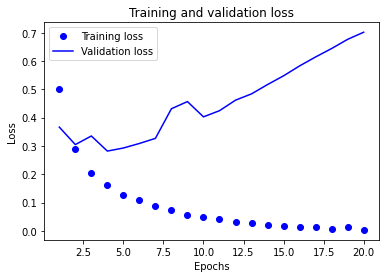

In [19]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

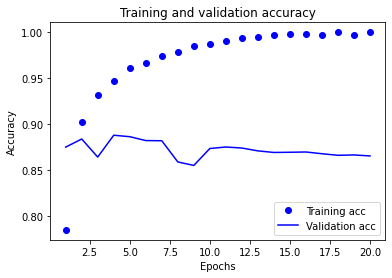

In [20]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [21]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 15ms/step - loss: 0.4487 - accuracy: 0.8255
Epoch 2/4
49/49 [==============================] - 1s 16ms/step - loss: 0.2577 - accuracy: 0.9106
Epoch 3/4
49/49 [==============================] - 1s 17ms/step - loss: 0.1980 - accuracy: 0.9294 0s - loss: 0.1988 - accuracy: 
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2940 - accuracy: 0.8838


In [22]:
results

[0.29402464628219604, 0.883840024471283]

### Using a trained model to generate predictions on new data

In [23]:
model.predict(x_test)

array([[0.23658529],
       [0.9994514 ],
       [0.83155537],
       ...,
       [0.1629447 ],
       [0.06790239],
       [0.58864844]], dtype=float32)

### Further experiments

1. More representation layers.

In [41]:
# build model
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    # adding an extra Dense layer
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 6s 39ms/step - loss: 0.5200 - accuracy: 0.7759 - val_loss: 0.3864 - val_accuracy: 0.8617
Epoch 2/5
30/30 [==============================] - 1s 24ms/step - loss: 0.2927 - accuracy: 0.9057 - val_loss: 0.2964 - val_accuracy: 0.8862
Epoch 3/5
30/30 [==============================] - 1s 23ms/step - loss: 0.2080 - accuracy: 0.9295 - val_loss: 0.2959 - val_accuracy: 0.8788
Epoch 4/5
30/30 [==============================] - 1s 24ms/step - loss: 0.1569 - accuracy: 0.9468 - val_loss: 0.2830 - val_accuracy: 0.8886
Epoch 5/5
30/30 [==============================] - 1s 24ms/step - loss: 0.1295 - accuracy: 0.9587 - val_loss: 0.2986 - val_accuracy: 0.8851


2. Less representation layers

In [40]:
# build model
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    # removing a Dense layer
    #layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 2s 41ms/step - loss: 0.4945 - accuracy: 0.7953 - val_loss: 0.3808 - val_accuracy: 0.8709
Epoch 2/5
30/30 [==============================] - 1s 26ms/step - loss: 0.3090 - accuracy: 0.9056 - val_loss: 0.3170 - val_accuracy: 0.8828
Epoch 3/5
30/30 [==============================] - 1s 25ms/step - loss: 0.2409 - accuracy: 0.9260 - val_loss: 0.3272 - val_accuracy: 0.8650
Epoch 4/5
30/30 [==============================] - 1s 23ms/step - loss: 0.1981 - accuracy: 0.9399 - val_loss: 0.2802 - val_accuracy: 0.8877
Epoch 5/5
30/30 [==============================] - 1s 23ms/step - loss: 0.1684 - accuracy: 0.9494 - val_loss: 0.2749 - val_accuracy: 0.8889


3. Layers with more units.

In [39]:
# build model
model = keras.Sequential([
    # increasing units
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 2s 51ms/step - loss: 0.4804 - accuracy: 0.7887 - val_loss: 0.3386 - val_accuracy: 0.8766
Epoch 2/5
30/30 [==============================] - 1s 28ms/step - loss: 0.2630 - accuracy: 0.9091 - val_loss: 0.3062 - val_accuracy: 0.8743
Epoch 3/5
30/30 [==============================] - 1s 29ms/step - loss: 0.1928 - accuracy: 0.9319 - val_loss: 0.3291 - val_accuracy: 0.8682
Epoch 4/5
30/30 [==============================] - 1s 28ms/step - loss: 0.1486 - accuracy: 0.9471 - val_loss: 0.3018 - val_accuracy: 0.8846
Epoch 5/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1174 - accuracy: 0.9612 - val_loss: 0.3041 - val_accuracy: 0.8840


4. Layers with less units.

In [38]:
# build model
model = keras.Sequential([
    # decreasing units
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 4s 114ms/step - loss: 0.5823 - accuracy: 0.7274 - val_loss: 0.4842 - val_accuracy: 0.8209
Epoch 2/5
30/30 [==============================] - 1s 25ms/step - loss: 0.3929 - accuracy: 0.8921 - val_loss: 0.3625 - val_accuracy: 0.8825
Epoch 3/5
30/30 [==============================] - 1s 27ms/step - loss: 0.2852 - accuracy: 0.9193 - val_loss: 0.3091 - val_accuracy: 0.8858
Epoch 4/5
30/30 [==============================] - 1s 24ms/step - loss: 0.2217 - accuracy: 0.9322 - val_loss: 0.2810 - val_accuracy: 0.8934
Epoch 5/5
30/30 [==============================] - 1s 23ms/step - loss: 0.1798 - accuracy: 0.9441 - val_loss: 0.2770 - val_accuracy: 0.8904


5. Changing loss function from `binary_crossentropy` to `mse`.

In [37]:
# build model
model = keras.Sequential([
    
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              # changing loss function
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 5s 132ms/step - loss: 0.5052 - accuracy: 0.7897 - val_loss: 0.3817 - val_accuracy: 0.8665
Epoch 2/5
30/30 [==============================] - 1s 27ms/step - loss: 0.3057 - accuracy: 0.8993 - val_loss: 0.3356 - val_accuracy: 0.8618
Epoch 3/5
30/30 [==============================] - 1s 25ms/step - loss: 0.2204 - accuracy: 0.9296 - val_loss: 0.2867 - val_accuracy: 0.8875
Epoch 4/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1721 - accuracy: 0.9425 - val_loss: 0.2844 - val_accuracy: 0.8873
Epoch 5/5
30/30 [==============================] - 1s 24ms/step - loss: 0.1424 - accuracy: 0.9536 - val_loss: 0.3040 - val_accuracy: 0.8819


5. Changing activation function from `relu` to `tanh`.

In [36]:
# build model
model = keras.Sequential([
    # chaning activation function
    layers.Dense(16, activation="tanh"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              # changing loss function
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 2s 38ms/step - loss: 0.4995 - accuracy: 0.7972 - val_loss: 0.3677 - val_accuracy: 0.8742
Epoch 2/5
30/30 [==============================] - 1s 24ms/step - loss: 0.2850 - accuracy: 0.9093 - val_loss: 0.3062 - val_accuracy: 0.8771
Epoch 3/5
30/30 [==============================] - 1s 24ms/step - loss: 0.2006 - accuracy: 0.9349 - val_loss: 0.2734 - val_accuracy: 0.8893
Epoch 4/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1511 - accuracy: 0.9495 - val_loss: 0.2813 - val_accuracy: 0.8862
Epoch 5/5
30/30 [==============================] - 1s 23ms/step - loss: 0.1165 - accuracy: 0.9625 - val_loss: 0.3000 - val_accuracy: 0.8835


<a name='multiclass'></a>
## 4.2. Classifying newswires: A multiclass classification example

### The Reuters dataset

**Loading the Reuters dataset**

In [0]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

In [0]:
len(train_data)

In [0]:
len(test_data)

In [0]:
train_data[10]

**Decoding newswires back to text**

In [0]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

In [0]:
train_labels[10]

### Preparing the data

**Encoding the input data**

In [0]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [0]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

**Model definition**

In [0]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

In [0]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

**Plotting the training and validation loss**

In [0]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

In [0]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [0]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

In [0]:
results

In [0]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

### Generating predictions on new data

In [0]:
predictions = model.predict(x_test)

In [0]:
predictions[0].shape

In [0]:
np.sum(predictions[0])

In [0]:
np.argmax(predictions[0])

### A different way to handle the labels and the loss

In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [0]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [0]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [0]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [0]:
train_data.shape

In [0]:
test_data.shape

In [0]:
train_targets

### Preparing the data

**Normalizing the data**

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [0]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [0]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [0]:
all_scores

In [0]:
np.mean(all_scores)

**Saving the validation logs at each fold**

In [0]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

**Building the history of successive mean K-fold validation scores**

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

In [0]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

In [0]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [0]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [0]:
test_mae_score

### Generating predictions on new data

In [0]:
predictions = model.predict(test_data)
predictions[0]

### Wrapping up

## Summary